In [ ]:
# installing openslide-python
!apt update && apt install -y openslide-tools
!pip install openslide-python

Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:13 https://developer.download.nvidia.co

In [ ]:
# importing required libraries
import openslide
import glob
import os
import matplotlib.pyplot as plt
import PIL
import math
import cv2
import numpy as np

In [ ]:
# Loading WSI folder which contains whole slide images into notebook
!unzip "/content/drive/MyDrive/WSI.zip"

Archive:  /content/drive/MyDrive/WSI.zip
   creating: WSI/
  inflating: WSI/wsi_3.svs           
  inflating: WSI/wsi_4.svs           
  inflating: WSI/wsi_5.svs           
  inflating: WSI/wsi_2.svs           
  inflating: WSI/wsi_1.svs           


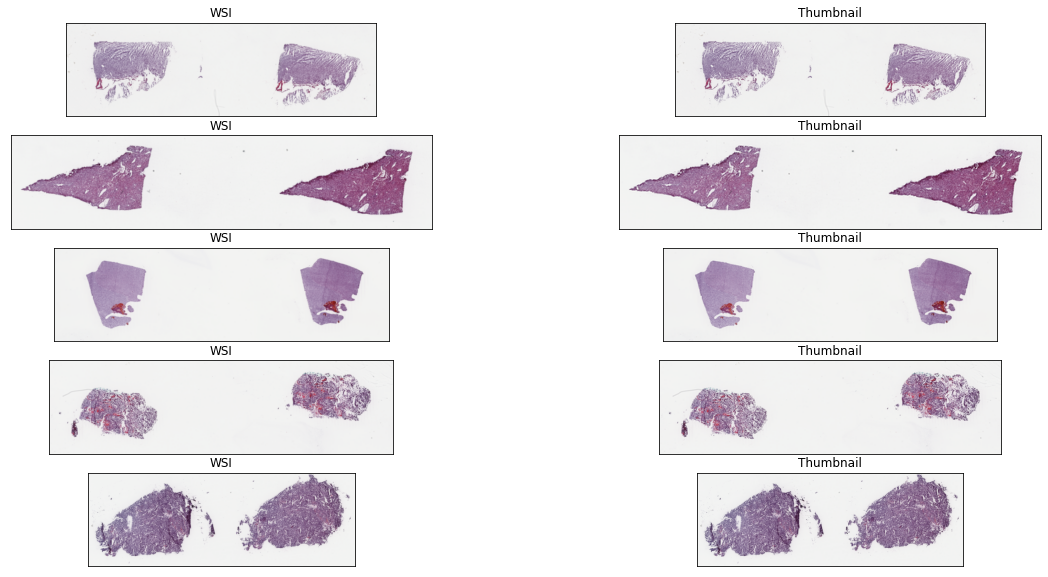

In [ ]:
plt.figure(figsize=(20,10))
dir_len=len(os.listdir("/content/WSI"))
i=1
for wsi_path in glob.glob("/content/WSI/*.svs"):

  # reading whole slide image using openslide.OpenSlide() function
  wsi=openslide.OpenSlide(wsi_path)

  # getting dimensions of the WSI
  width,height=wsi.dimensions

  # defining scale factor for downsampling WSI and setting its corresponding thumbnail size
  SCALE_FACTOR=150
  THUMBNAIL_SIZE=500

  # getting downsampled width and height for WSI
  new_w = math.floor(width / SCALE_FACTOR)
  new_h = math.floor(height / SCALE_FACTOR)

  # getting best level for downsampling WSI
  level = wsi.get_best_level_for_downsample(SCALE_FACTOR)

  # getting whole slide image and converting into RGB and then resizing it
  whole_slide_image = wsi.read_region((0, 0), level, wsi.level_dimensions[level])
  whole_slide_image = whole_slide_image.convert("RGB")
  wsi_img = whole_slide_image.resize((new_w, new_h), PIL.Image.BILINEAR)

  # getting thumbnail
  thumbnail=wsi.get_thumbnail((THUMBNAIL_SIZE,THUMBNAIL_SIZE))

  # plotting WSI and its thumbnail
  plt.subplot(dir_len,2,i)
  i+=1
  plt.title("WSI")
  plt.xticks([]),plt.yticks([])
  plt.imshow(wsi_img)
  plt.subplot(dir_len,2,i)
  i+=1
  plt.title("Thumbnail")
  plt.xticks([]),plt.yticks([])
  plt.imshow(thumbnail)
plt.show()

In [ ]:
# creating tiles directory
if not os.path.isdir("/content/tiles"):
  os.mkdir("/content/tiles")

In [ ]:
i=1
for wsi_path in glob.glob("/content/WSI/*.svs"):

  # reading WSI using openslide.OpenSlide() function
  wsi=openslide.OpenSlide(wsi_path)

  # defining patch size 
  patch_size=512

  # getting dimensions of WSI and upper bounds for n_across and n_down
  width,height=wsi.dimensions
  n_across=width//patch_size
  n_down=height//patch_size

  # initializing parameters
  n_patches=0
  j=1
  flag=0

  # iterating over WSI and extracting 512 X 512 tiles
  for y in range(n_down):
    for x in range(n_across):

      # Since each WSI generates around 12000 tiles each of 512 X 512, due to memory constraint I have stored only 10 tiles for each WSI
      if n_patches%1000==0:

        # getting tile using read_region() function
        patch=wsi.read_region((x*patch_size,y*patch_size),0,(patch_size,patch_size))

        # converting to RGB
        patch=patch.convert("RGB")

        # defining target directory to store tiles
        target_dir="wsi_%d"%(i)+"_tile_%d.bmp"%(j)

        # output path
        out_path=os.path.join("/content/tiles",target_dir)
        j+=1

        # saving patch in output path
        patch.save(out_path)

        # generating exactly 10 tiles for each WSI
        if j==11:
          flag=1
          break
      n_patches+=1

    # generating exactly 10 tiles for each WSI
    if flag==1:
      break
  i+=1

In [ ]:
import tensorflow as tf

In [ ]:
# getting image paths
import glob
data_dir = '/content/tiles/'
image_paths = glob.glob(data_dir + '*.bmp')

In [ ]:
import io

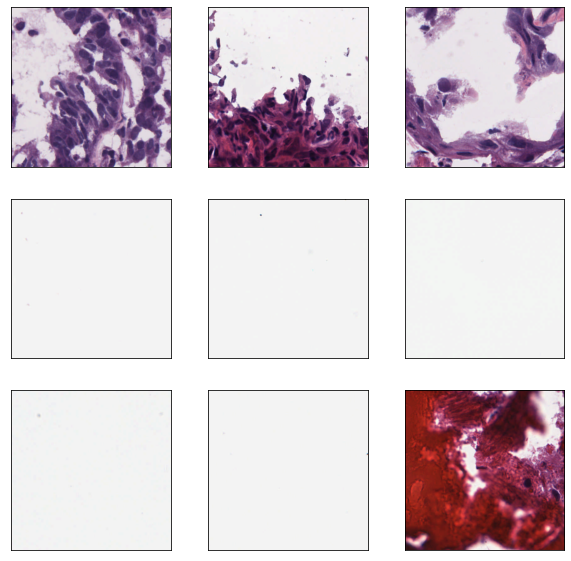

In [ ]:
# displaying first 9 tiles
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i, path in enumerate(image_paths[:9]):
    img = tf.keras.preprocessing.image.load_img(path,color_mode="rgb",interpolation="nearest")
    plt.subplot(3,3,i+1)
    plt.xticks([]),plt.yticks([])
    plt.imshow(img)
plt.show()

In [ ]:
# creating tf.train.Feature for byte,float and int
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() 
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [ ]:
# serialization
def serialize_example(image,image_shape):
    feature = {
        'image': _bytes_feature(image),
        'height': _int64_feature(image_shape[0]),
        'width': _int64_feature(image_shape[1]),
        'depth': _int64_feature(image_shape[2]),
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [ ]:
# writing to tfrecord

# output directory path for tfrecord
tfrecord_dir = '/content/data.tfrecord'

with tf.io.TFRecordWriter(tfrecord_dir) as writer:
    for image_path in image_paths:

        #loading image
        img = tf.keras.preprocessing.image.load_img(image_path)

        #converting image to array
        img_array = tf.keras.preprocessing.image.img_to_array(img)

        img_bytes = tf.io.serialize_tensor(img_array)
        image_shape = img_array.shape

        #serialize
        example = serialize_example(img_bytes,image_shape)

        #write
        writer.write(example)

In [ ]:
# function to read tfrecord
def read_tfrecord(serialized_example):
    feature_description = {
        'image': tf.io.FixedLenFeature((), tf.string),
        'height': tf.io.FixedLenFeature((), tf.int64),
        'width': tf.io.FixedLenFeature((), tf.int64),
        'depth': tf.io.FixedLenFeature((), tf.int64)
    }
    example = tf.io.parse_single_example(serialized_example, feature_description)
    
    image = tf.io.parse_tensor(example['image'],out_type=float)
    image_shape = [example['height'], example['width'], example['depth']]
    return image

<PIL.Image.Image image mode=RGB size=512x512 at 0x7FE135357E90>
<PIL.Image.Image image mode=RGB size=512x512 at 0x7FE132B32F50>
<PIL.Image.Image image mode=RGB size=512x512 at 0x7FE132AFDD10>
<PIL.Image.Image image mode=RGB size=512x512 at 0x7FE132ABD750>
<PIL.Image.Image image mode=RGB size=512x512 at 0x7FE132A801D0>
<PIL.Image.Image image mode=RGB size=512x512 at 0x7FE132ACE490>
<PIL.Image.Image image mode=RGB size=512x512 at 0x7FE132ACE5D0>
<PIL.Image.Image image mode=RGB size=512x512 at 0x7FE135492E90>
<PIL.Image.Image image mode=RGB size=512x512 at 0x7FE135157FD0>


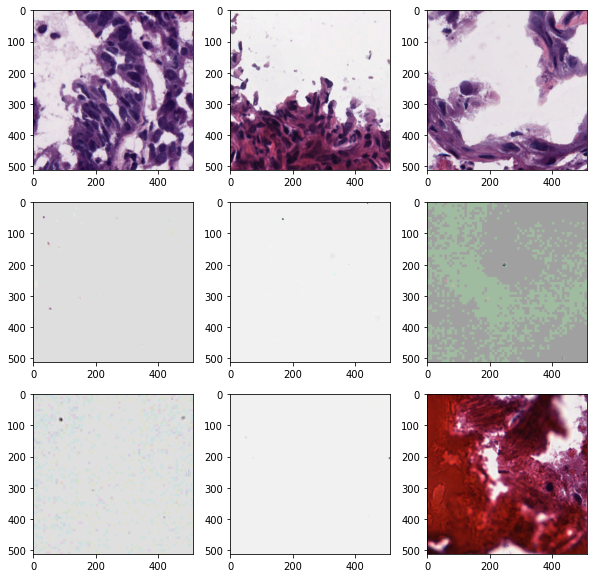

In [ ]:
# tfrecord reading
tfrecord_dataset = tf.data.TFRecordDataset(tfrecord_dir)
parsed_dataset = tfrecord_dataset.map(read_tfrecord)
plt.figure(figsize=(10,10))
for i, data in enumerate(parsed_dataset.take(9)):
    img = tf.keras.preprocessing.image.array_to_img(data)
    print(img)
    plt.subplot(3,3,i+1)
    plt.imshow(img)
plt.show()